# Sequence Likelihood

In [1]:
import transformer_lens, torch, tqdm
import numpy as np
from pathlib import Path
from toolz import compose

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import helpers, modelHandlers, dataLoaders

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
torch.set_grad_enabled(False)
model = modelHandlers.load_model(model_type="gpt-neo-125M", DEVICE="cuda")
modelHandlers.set_no_grad(model, ["embed", "pos_embed", "unembed"])

Loaded pretrained model gpt-neo-125M into HookedTransformer
set no_grad on ['embed', 'pos_embed', 'unembed']


## Loading seqs from the Pile

https://github.com/ethz-spylab/lm_memorization_data


filtering tokens and eos: 50256
count_ranges [[100, 1000]]
toks_NI shape: torch.Size([856, 100]), with max count 996


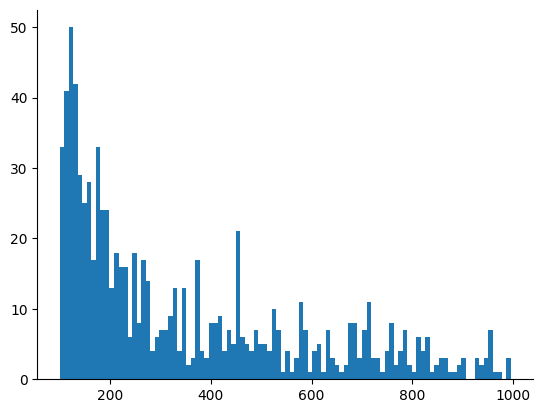

In [11]:
filter_str = ["license", "copyright", "software", "manuscript", "submission", "distribution", "disclaimed","limited"]
filter_toks = model.to_tokens(helpers.expand_filter_list(filter_str))
toks_NI, counts_N = dataLoaders.load_pile_seqs(seq_length=100, n_seqs=1000000, uni_tok_frac=0.7, filter_toks=filter_toks, count_ranges=[[100,1000]], k_uniform=None)
print(f"toks_NI shape: {toks_NI.shape}, with max count {max(counts_N).item()}")
counts, bins = np.histogram(counts_N, bins=100)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [12]:
def get_first2sec(nll_NIT, toks_NI):

    nll_NI = helpers.gather_token_scores(nll_NIT, toks_NI, pool=[])
    nll_NIk, idcs_NIk = helpers.get_topK(nll_NIT, topK=2, minK=True)
    idcs_NI_top1, idcs_NI_top2 = nll_NIk[...,:-1,0], nll_NIk[...,:-1,1]
    
    ## (1) first2sec gap
    top1_nll_NI = -(nll_NIk[...,:-1,0] - nll_NI) ## first to toks (negative)
    nll_top2_NI = -(nll_NIk[...,:-1,1] - nll_NI) ## sec to toks (positive)
    top1_nll_NI[top1_nll_NI==0.0] = nll_top2_NI[top1_nll_NI==0.0]

    ## get first index when toks take over
    first2sec_cumsum = torch.cumsum(top1_nll_NI[:,:], dim=-1)
    #seq_len = torch.arange(0,first2sec_cumsum.shape[-1],1)+1 
    #first2sec_cummean = torch.einsum("...I,...NI->NI", (1/seq_len), first2sec_cumsum)    
    nonz = (first2sec_cumsum >= 0)
    _, idcs = ((nonz.cumsum(-1) == 1) & nonz).max(-1) 
    idcs[idcs==0] = nonz.shape[-1]-1
    #print(idcs, first2sec_cumsum.shape)
    #print(idcs.shape)
    
    nll_NI_cumsum = torch.cumsum(nll_NI[:,:], dim=-1)
    #print(nll_NI_cumsum.shape, idcs)
    #cumsum = torch.index_select(nll_NI_cumsum, dim=-1, index=idcs)
    cumsum = nll_NI_cumsum[torch.arange(0,nll_NI_cumsum.shape[0]),idcs]
    return cumsum #idcs/ nonz.shape[-1]


str_NI = "Twinkle, twinkle little star how I wonder what"
str_NI = "Jingle Bells, Jingle Bells, Jingle all the way. Oh what fun it is to ride in a one horse open sleigh. Jingle Bells, Jingle Bells, Jingle all the way. Oh what fun it is to ride in a one horse open sleigh."
str_NI = "Why?\n\nA woman I know, the stay-at-home wife of a mogul -- "
str_NI = "Jeff Dean is an AI researcher born in Hawai, USA --- "
str_NI = "Our Father, Who art in heaven, Hallowed be Thy Name. Thy Kingdom come, Thy Will be done, On earth as it is in Heaven."
str_NI = "And forgive us our trespasses, as we forgive those who trespass against us. And lead us not into temptation, but deliver us from evil."

#str_NI = "In the town where I was born. Lived a man who sailed to sea. And he told us of his life. In the land of submarines"
#str_NI = "So we sailed on to the sun. Till we found the sea of green. And we lived beneath the waves. In our yellow submarine"
str_NI = "An apple a day keeps the doctor away"

#toks_NI = model.to_tokens(str_NI)
#logs_NIT = model(toks_NI)
#nll_NIT = helpers.NegLogLik(logs_NIT)
#nll_NI = helpers.gather_token_scores(nll_NIT, toks_NI, pool=[])
#get_first2sec(nll_NIT, toks_NI)
#nll_NI.mean()

In [13]:
def compute_seq_metrics(model, toks_NI:torch.LongTensor, batch_size:int=5):
    
    toks_NI = toks_NI.to(model.cfg.device) ## detach and put on device
    mean_nll_N, minK_nll_N, first2sec_N = torch.zeros(toks_NI.shape[0]), torch.empty(toks_NI.shape[0]), torch.empty(toks_NI.shape[0])

    toks_BNI = torch.split(toks_NI.detach(), batch_size, dim=0) ## split in batches
    for b, batched_toks_NI in enumerate(tqdm.tqdm(toks_BNI)):
        
        batched_toks_NI = batched_toks_NI.detach()
        logs_NIT = model(batched_toks_NI)
        nll_NIT = helpers.NegLogLik(logs_NIT)
        nll_NI = nll_NIT.gather(dim=-1, index=batched_toks_NI[:, 1:, None])[:, :, 0] 
        #nll_NI = helpers.gather_token_scores(nll_NIT, toks_NI, pool=[])

        mean_nll = nll_NI.mean(-1) ## (1) NLL mean
        nll_Nk, idcs_Nk = torch.topk(nll_NI, k=int(0.2*nll_NI.shape[-1]), largest=True, dim=-1) ## (2) minK
        minK_nll = nll_Nk.mean(-1)
        first2sec = get_first2sec(nll_NIT, batched_toks_NI) ## (3) first2sec nnl gap

        current_B = batched_toks_NI.shape[0]
        mean_nll_N[b*batch_size:(b*batch_size)+current_B] = mean_nll
        minK_nll_N[b*batch_size:(b*batch_size)+current_B] = minK_nll
        first2sec_N[b*batch_size:(b*batch_size)+current_B] = first2sec
    return mean_nll_N, minK_nll_N, first2sec_N

mean_nll_N, minK_nll_N, first2sec_N = compute_seq_metrics(model, toks_NI, batch_size=40)

100%|██████████| 22/22 [00:13<00:00,  1.66it/s]


Text(0, 0.5, 'NLL loss metric')

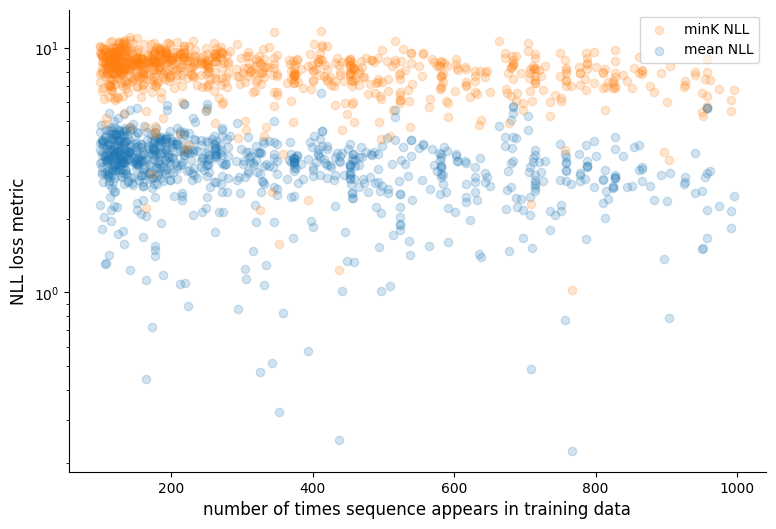

In [20]:


fontsize = 12
fig, ax = plt.subplots(1, 1, figsize=(9, 6), gridspec_kw={'hspace': 0.4})

x = counts_N.cpu().numpy()
mean = ax.scatter(x, mean_nll_N.detach().cpu().numpy(), alpha=0.2, label="mean NLL")
minK = ax.scatter(x, minK_nll_N.detach().cpu().numpy(), alpha=0.2, label="minK NLL")
ax.legend(handles=[minK, mean], loc='upper right') #minK, mean, 

ax.set_yscale('log')
ax.set_xlabel('number of times sequence appears in training data', fontsize=fontsize)
ax.set_ylabel('NLL loss metric', fontsize=fontsize)
#top1, = ax.plot(x, top_logits[...,0,:].detach().squeeze().numpy(), label="")
#top2, = ax.plot(x, top_logits[...,1,:].detach().squeeze().numpy(), label=f"top2 {model.to_string(top_indc[...,1,:])}")


Text(0, 0.5, 'first2second saturation')

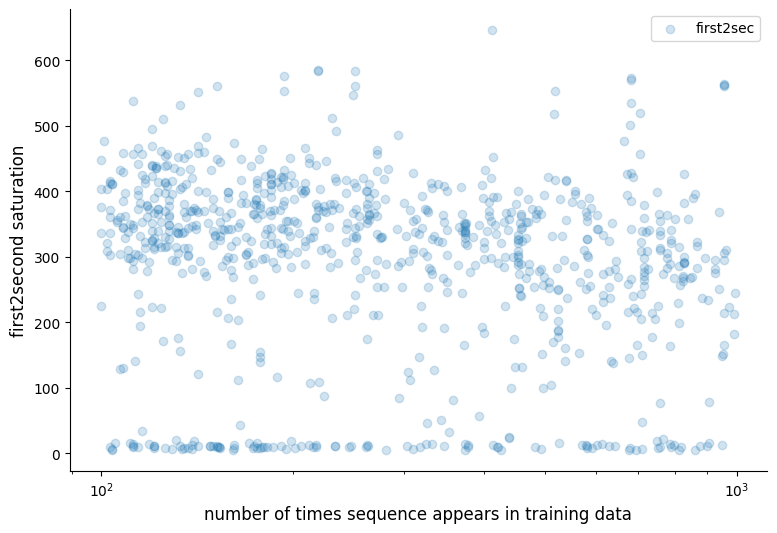

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fontsize = 12
fig, ax = plt.subplots(1, 1, figsize=(9, 6), gridspec_kw={'hspace': 0.4})

x = counts_N.numpy()
line = ax.scatter(x, first2sec_N.detach().cpu().numpy(), alpha=0.2, label="first2sec")
ax.legend(handles=[line], loc='upper right') #minK, mean, 

ax.set_xscale('log')
ax.set_xlabel('number of times sequence appears in training data', fontsize=fontsize)
ax.set_ylabel('first2second saturation', fontsize=fontsize)


In [31]:
idcs = torch.where(first2sec_N < 50.2, 1, 0).nonzero().squeeze()
print(mean_nll_N.shape, idcs.shape)
model.to_string(toks_NI[idcs[:30]])

torch.Size([856]) torch.Size([113])


['.\n\nSELF-REPRESENTED LITIGANTS MAY SERVE DOCUMENTS BY E-MAIL; HOWEVER, THEY ARE NOT\nREQUIRED TO DO SO. If a self-represented litigant elects to serve and receive documents by e-mail, the\nprocedures must always be followed once the initial election is made.\n\nTo serve and receive documents by e-mail, you must designate your e-mail addresses by using',
 " listening to all sides of the story and giving a 'voice to the voiceless.'\nReaching more than 270 million households in over 140 countries across the globe, our viewers trust Al Jazeera English to keep them informed, inspired, and entertained.\nOur impartial, fact-based reporting wins worldwide praise and respect. It is our unique brand of journalism that the world has come to rely on.\nWe are reshaping global media and constantly working to strengthen our reputation as one of the world's most",
 ". By signing up you are agreeing to our Terms of Use and Privacy Policy . This site is protected by reCAPTCHA and the Google Privacy P

In [68]:
model.cpu()

Moving model to device:  cpu


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [34]:
a = ".\n\nTrinidad has the highest rate of Islamic State recruitment in the Western hemisphere. How did this happen?\n\nThis summer, the so-called Islamic State published issue 15 of its online magazine Dabiq. In what has become a standard feature, it ran an interview with an ISIS foreign fighter. “When I was around twenty years old I would come to accept the religion of truth, Islam,” said Abu Sa’d at-Trinidadi,'"
b = model.generate(input=a[:-50], max_new_tokens=50, stop_at_eos=True, eos_token_id=None, do_sample=False, top_k=None, top_p=None, temperature=1.0)
b

  0%|          | 0/50 [00:00<?, ?it/s]

'.\n\nTrinidad has the highest rate of Islamic State recruitment in the Western hemisphere. How did this happen?\n\nThis summer, the so-called Islamic State published issue 15 of its online magazine Dabiq. In what has become a standard feature, it ran an interview with an ISIS foreign fighter. “When I was around twenty years old I would come to accept the religi\xadous teachings of the Prophet Muhammad,” Trinidad said. “I would say to myself, ‘I’m not going to accept the teachings of the Prophet Muhammad.’”\n\nThe Islamic State'